# Let's start by installing all required libraries

In [31]:
!pip install numpy scikit_learn matplotlib seaborn pandas tifffile -q

## Load a csv table containing morphometric measurements for single cells as well as manual annotations of their cell cycle phase

In [32]:
import pandas as pd

data = pd.read_csv("../data/morphological_measurements.csv")

## Take a look at our data

In [33]:
data

,Cell ID,Area,Perimeter,Length,Width,Eccentricity,Irregularity,Cell Cycle Phase
0,1,182,57,16.000000,13.000000,0.582961,4.225121,1
1,2,211,64,16.552945,15.231546,0.391516,4.405942,1
2,3,237,67,18.027756,14.866069,0.565685,4.352118,1
3,4,227,66,17.000000,16.000000,0.337915,4.380574,1
4,5,204,60,15.000000,15.000000,0.000000,4.200840,1
...,...,...,...,...,...,...,...,...
529,448,389,85,24.351591,20.248457,0.555518,4.309671,1
530,449,420,87,23.000000,21.000000,0.407862,4.245165,2
531,452,450,91,25.961510,20.615528,0.607813,4.289781,3
532,453,424,89,25.495098,21.213203,0.554700,4.322222,3


<Axes: >

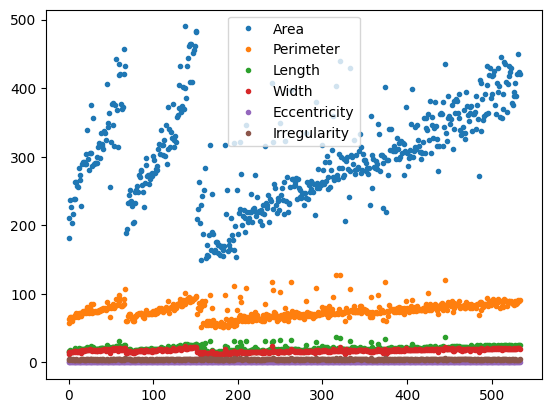

In [34]:
data[[ 'Area', 'Perimeter', 'Length', 'Width', 'Eccentricity',
       'Irregularity']].plot(ls='',marker='.')

<Axes: >

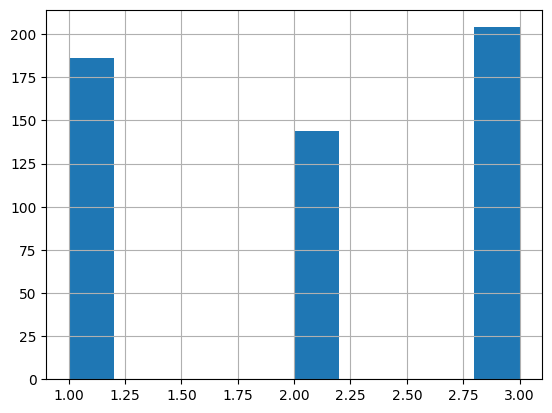

In [35]:
data['Cell Cycle Phase'].hist()

## Let's try to create a basic classifier for cell cycle stage
### First we need to normalize the data to mean 0 and std 1

In [36]:
from sklearn.preprocessing import StandardScaler

rows, columns = data.shape

## shuffle data
data = data.sample(frac=1,replace=False,random_state=0).reset_index(drop=True)

## standardize variables
cols = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity','Irregularity']

for col in cols:
  scaler = StandardScaler()
  data[col+"_scaled"] = scaler.fit_transform(data[[col]])

## split into train, test
train = data.loc[0:int(rows*0.8), :].copy() #separates 80% of data as training data
test = data.loc[int(rows*0.8):, :].copy() #separates 20% of data as validation data

In [37]:
from sklearn.linear_model import LogisticRegression

x_cols = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity','Irregularity']
y_col = 'Cell Cycle Phase'

# fit on training set
clf = LogisticRegression().fit(train[x_cols],train[y_col])

# predictions on test set
preds = clf.predict(test[x_cols])
# accuracy on test set
sum(preds==test[y_col])/test.shape[0]

/Users/bsaraiva/mambaforge/envs/bioimagecourse/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.514018691588785

In [38]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

conf_mat = confusion_matrix(test[y_col],preds,normalize='true')
conf_mat

array([[0.7       , 0.075     , 0.225     ],
       [0.29411765, 0.11764706, 0.58823529],
       [0.27272727, 0.03030303, 0.6969697 ]])

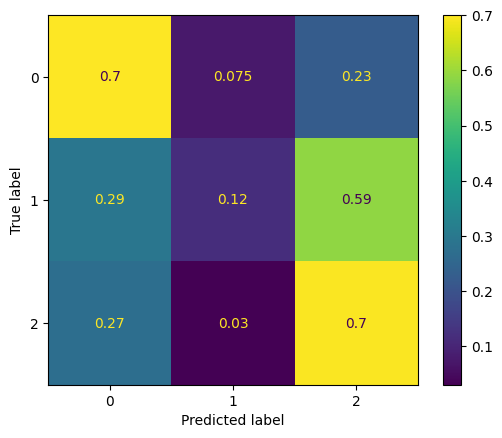

In [39]:
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()

## Could this crappy model be explained by class inbalance?

We have 147 cells in phase 1, 110 cells in phase 2 and 171 cells in phase 3


<Axes: >

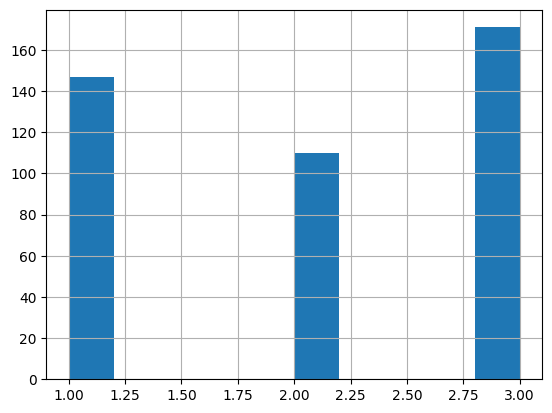

In [40]:
p1, p2, p3 = train[train['Cell Cycle Phase']==1].shape[0], train[train['Cell Cycle Phase']==2].shape[0], train[train['Cell Cycle Phase']==3].shape[0]
print(f"We have {p1} cells in phase 1, {p2} cells in phase 2 and {p3} cells in phase 3")
train['Cell Cycle Phase'].hist()

## We need to balance our classes, we can start by trying to oversample the minority classes

<Axes: >

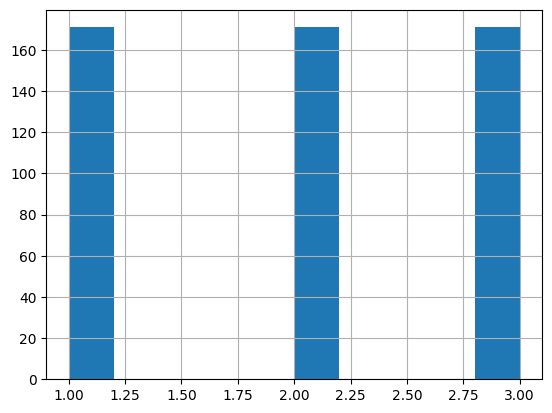

In [41]:
train_oversampled = pd.concat([train,train[train['Cell Cycle Phase']==2].sample(n=p3-p2,replace=True) ]).reset_index(drop=True)
train_oversampled = pd.concat([train_oversampled,train[train['Cell Cycle Phase']==1].sample(n=p3-p1,replace=True) ]).reset_index(drop=True)
train_oversampled['Cell Cycle Phase'].hist()

## Let's try again training the classifier and see if it improved

array([[0.55      , 0.35      , 0.1       ],
       [0.20588235, 0.44117647, 0.35294118],
       [0.15151515, 0.21212121, 0.63636364]])

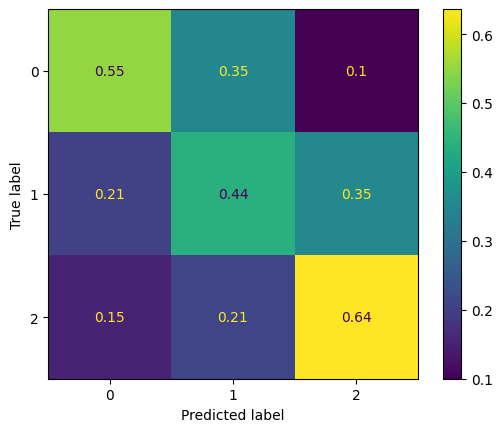

In [42]:
from sklearn.linear_model import LogisticRegression

x_cols = [col+'_scaled' for col in cols]
y_col = 'Cell Cycle Phase'

# fit on training set
clf = LogisticRegression().fit(train_oversampled[x_cols],train_oversampled[y_col])

# predictions on test set
preds = clf.predict(test[x_cols])

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

conf_mat = confusion_matrix(test[y_col],preds,normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
conf_mat

## Better but still not great, let's try other classifiers
### Thankfully, all classifiers in `sklearn` obey the same API, ie, they all have the methods:

* `fit()`
* `predict()`
* `predict_proba()`

## but wait, as we tweak our model or testing different models, if we keep testing against the test set, we incur in **data leakage**. that is, we are inplicily fitting against the test set. This is not good


We have a few options:
* we can make many train/test splits (**BAD**)
* we can bootstrap our training set, always testing against the same test set (Also **BAD**)
* OR you can do cross-validation (better)

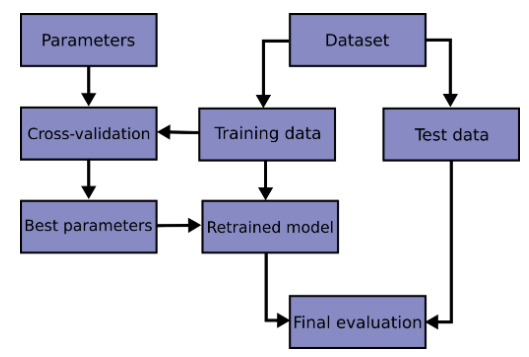
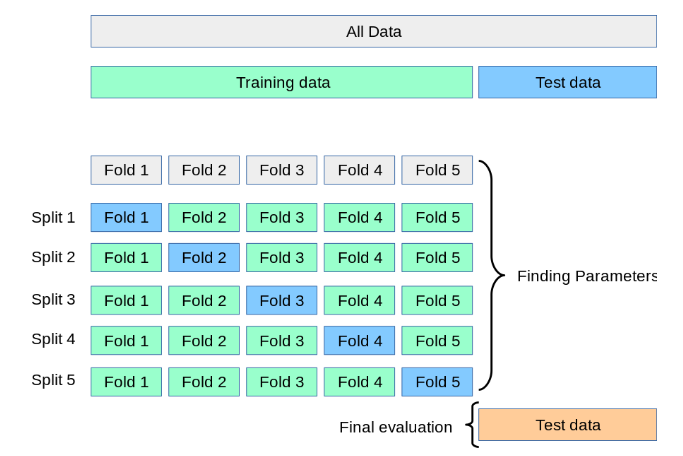

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [43]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
import numpy as np

clf = LogisticRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
scores = cross_val_score(clf, train_oversampled[x_cols], train_oversampled['Cell Cycle Phase'], cv=cv,scoring='accuracy')

print(scores)
print("cross-validated mean and standard deviation:", np.mean(scores),np.std(scores))


[0.48543689 0.55339806 0.45631068 0.55339806 0.46601942]
cross-validated mean and standard deviation: 0.5029126213592233 0.042274837004033464


## Now that we have our cross-validation working, let's try it to train different classifiers

In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025,probability=True),
    SVC(gamma=2, C=1,probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

results = []

for name,clf in zip(names,classifiers):
    print(name)

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
    scores = cross_val_score(clf, train_oversampled[x_cols], train_oversampled['Cell Cycle Phase'], cv=cv,scoring='accuracy')
    print(np.mean(scores))
    results.append({"model":name,"train_acc_mean":np.mean(scores),"train_acc_std":np.std(scores)})

results_df= pd.DataFrame(results)

Logistic Regression
0.5029126213592233
Nearest Neighbors
0.4990291262135923
Linear SVM
0.5262135922330098
RBF SVM
0.5398058252427184
Gaussian Process
0.537864077669903
Decision Tree
0.5320388349514562
Random Forest
0.5689320388349515
Neural Net
0.5184466019417476
AdaBoost
0.5572815533980583
Naive Bayes
0.5126213592233009
QDA
0.47961165048543697


/Users/bsaraiva/mambaforge/envs/bioimagecourse/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/bsaraiva/mambaforge/envs/bioimagecourse/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/bsaraiva/mambaforge/envs/bioimagecourse/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/bsaraiva/mambaforge/envs/bioimagecourse/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the 

### Let's plot our models accuracies

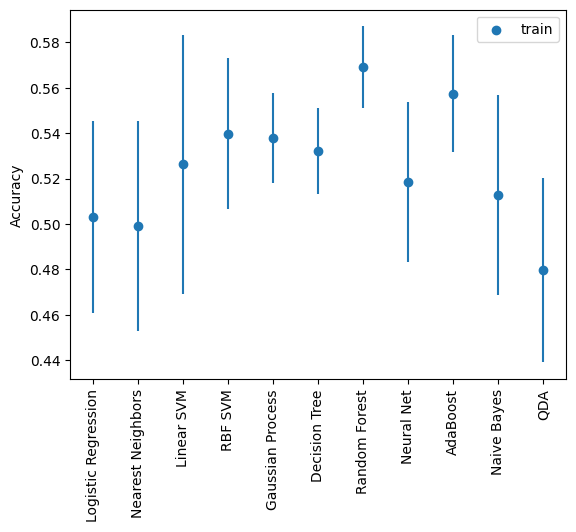

In [48]:
from matplotlib import pyplot as plt
plt.scatter(results_df['model'],results_df['train_acc_mean'],label='train');
plt.vlines(results_df['model'],results_df['train_acc_mean']-results_df['train_acc_std'],results_df['train_acc_mean']+results_df['train_acc_std'])
# plt.scatter(results_df['model'],results_df['test_auc'],label='test');
plt.xticks(rotation=90);
plt.ylabel("Accuracy")
plt.legend();

In [49]:
# TODO add fine tunning example of one of the models
# TODO add exercise to classify well segmented and badly segmented cells